## TF.UEBVeg.WSC_Tsurf
### Purpose:
- Preperation and driver script for UEBVeg experiment demonstrating added value of Tsurf
- Intended as simple modeling experiment for WSC16

In [1]:
####################################################################################################
# TF.UEBVeg.WSC16_Tsurf.ipynb
# Karl Lapo April/2016
####################################################################################################
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
import kray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dir_data = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/WSC16'
dir_senatorBeckRaw = dir_pre+'/GroundObs/SenatorBeck/Raw'
dir_print = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/WSC16'
dir_modelUEBVeg = '/home/lapok/snowModels/UEBVeg'

# List of sub-directory names for each data set
dir_modelINPUT = dir_modelUEBVeg+'/TsDemo.INPUT'
dir_modelOUTPUT = dir_modelUEBVeg+'/TsDemo.OUTPUT'
dir_modelOUTPUT_Mark = dir_data+'/TsDemo_Mark.OUTPUT'

/home/lapok/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/lapok/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Functions

In [3]:
## These still require some testing to make sure they are physical...
def stability(Tair,Tsurf,U,z=2):
    g = 9.81
    Ri = g*z*(Tair-Tsurf)/(.5*(Tair+Tsurf)*U**2)
    return(Ri)

# Ri = stability(ds.Tair.values,ds.Tsurf.values+273.16,ds.WIND.values,z=3)


## Data

In [2]:
## MATLAB met data @ Swamp Angel from the Melt Sensitivity experiments
# See script with matlab output: /home/lapok/gdrive/SnowHydrology/proj/metData_SwampAngel_matlab.m
os.chdir(dir_data)

swampAngel_MATLAB = 'swampAngel.metDataMeltSensivitiy.matlab.txt'
swampAngel = pd.read_csv(swampAngel_MATLAB,sep= '\t', parse_dates='datetime', index_col='datetime')

# elevation/lat/lon
elev = 3371
lat = 37.9069
lon = -107.7113


In [3]:
## Surface temperature observations @ Swamp Angel from observation file
os.chdir(dir_senatorBeckRaw)
def parser(x):
    return(pd.datetime.strptime(x, '%Y %j %H'))

def hourConverter(x):
    x = float(x)-100.
    if x >= 1000.:
        x = str(int(x/100))
    elif x < 1000. and x >= 0.:
        x = '0'+str(int(x/100))
    return x

swampAngel_RAW = 'SASP_1hr.listForPandas.txt'
swampAngel_RAW = pd.read_csv(swampAngel_RAW,sep= ',',\
                                converters={'Hour': hourConverter},\
                                parse_dates={'datetime': ['Year','DOY','Hour']},\
                                date_parser=parser,index_col='datetime')

# Assign to swampAngel dataFrame
swampAngel['Ts'] = swampAngel_RAW.Sno_IR_C

In [4]:
## Empty met values
swampAngel['Qg'] = pd.Series(np.ones_like(swampAngel['T'].values)*-9999, index=swampAngel.index)
swampAngel['Qg'] = swampAngel.Qg.astype('int')
swampAngel['RadNet'] = pd.Series(np.ones_like(swampAngel['T'].values)*-9999, index=swampAngel.index)
swampAngel['RadNet'] = swampAngel.RadNet.astype('int')
swampAngel['Trange'] = pd.Series(np.ones_like(swampAngel['T'].values)*10, index=swampAngel.index)
swampAngel['Trange'] = swampAngel.Trange.astype('int')

## Convert to UEB's horrific units
swampAngel['SW'] = swampAngel['SW']*3.6
swampAngel['SW'][swampAngel['EL'] == 0] = 0
swampAngel['LW'] = swampAngel['LW']*3.6
swampAngel['P'] = swampAngel['P']/1000

/home/lapok/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model parameter and forcing files

Need:
- bcparam.dat
- driver.in
- met.in
- param.dat
- sitev.dat

In [6]:
scenarioNames = ['exp'+str(y) for y in np.arange(0,25)]
siteName = 'SASP'

dlogzo = 4./25.
zo = [10**logzo for logzo in np.arange(-5,-1+dlogzo,4./25)]

In [7]:
for sc,z in zip(scenarioNames,zo):
    # Output filename
    outputFilename = dir_modelINPUT+'/'+siteName+'.'+sc+'.out'
    
    # bcparam.dat
    exampleParam = dir_modelUEBVeg+'/example.INPUT/TWDEF.example.bcparam.dat'
    bcparamFilename = dir_modelINPUT+'/'+siteName+'.'+sc+'.bcparam.dat'
    os.system('cp '+exampleParam+' '+bcparamFilename)

    # sitev.dat
    sitevFilename = dir_modelINPUT+'/'+siteName+'.'+sc+'.sitev.dat'
    sitev = '1.0  74051  0. 0.1 0. 0. 0. 0. 1.0     df   pr(PA)  qg  aep  Cc Hc LAI Sbar Ycage \n'\
            '0. 0.  37.9069   slope aspect lat'
    f = open(sitevFilename,'w')
    f.write(sitev)
    f.close()

    # param.dat
    paramFilename = dir_modelINPUT+'/'+siteName+'.'+sc+'.param.dat'
    paramPre = '3 -1  0.99  2.09 2 '
    paramPost = str(z)+'  337 1700 \n'\
            '0.05 20 0.1  0.25 0.85 0.65 \n'\
            '1.0 4.0 0.0654 1 1.0 -0.45 0.001 \n'\
            '0 .98 0.5 0.0 0.5 .004626286 0.25 .5 .857143 .16 0.5 \n'
    param = paramPre+paramPost
    f = open(paramFilename,'w')
    f.write(param)
    f.close()
    
    # met.in
    # Leading 2 lines of time series file
    metFilename = dir_modelINPUT+'/'+siteName+'.'+sc+'.met.in'
    metLine1 = [swampAngel.index.month[0],swampAngel.index.day[0],swampAngel.index.year[0],\
                swampAngel.index.hour[0],1,0,0,0,0,-9999]
    metLine1Str = "\t".join(np.char.mod('%u', metLine1))
    metLine2 = [0,2,1]
    metLine2Str = "\t".join(np.char.mod('%u', metLine2))

    f = open(metFilename,'w')
    f.write(metLine1Str)
    f.write('\n')
    f.write(metLine2Str)
    f.write('\n')
    f.close()
    
    # Forcing met time series
    swampAngel.to_csv(path_or_buf=metFilename,mode='a',columns=['T','P','WIND','RH','Trange',\
                                                                'SW','Qg','RadNet','LW'],\
                     header=False,index=False,sep='\t')
    
    # driver.in
    driverFileName = dir_modelINPUT+'/'+siteName+'.'+sc+'.driver.in'
    driver =    siteName+'.'+sc+'.met.in' +'\n'+\
                siteName+'.'+sc+'.out' +'\n'+\
                siteName+'.'+sc+'.param.dat' +'\n'+\
                siteName+'.'+sc+'.sitev.dat' +'\n'+\
                siteName+'.'+sc+'.bcparam.dat' +'\n'+\
                str(2)
    f = open(driverFileName,'w')
    f.write(driver)
    f.close()

In [8]:
## Masterlist
masterlistFilename = dir_modelUEBVeg+'/masterlist.txt'
masterlist = [siteName+'\t'+sc+'\n' for sc in scenarioNames]
masterlist = "".join(masterlist)
f = open(masterlistFilename,'w')
f.write(masterlist)
f.close()


# python driverUEBVeg.py TsDemo

## Model Output Aggregation and Analysis

In [9]:
## Read modified output files
os.chdir(dir_modelOUTPUT)
SWA = xray.Dataset({'Ts' : ('time', swampAngel.Ts),\
                    'SWE' : ('time', swampAngel.SWE/1000)},\
                   coords={'time': swampAngel.index.values})
print(SWA)

def parser(x):
    return(pd.datetime.strptime(x, '%Y %m %d %H'))

dfSWE = {}
dfTs = {}

for sc,z in zip(scenarioNames,zo):
    # Output filename
    outputFilename = dir_modelOUTPUT+'/'+siteName+'.'+sc+'.modify.out'
    df = pd.read_csv(outputFilename,sep= '\s', parse_dates={'time' : ['Year','Month','Day','Hour']},\
                date_parser=parser,index_col='time',engine='python')
    dfSWE[sc] = pd.DataFrame(df['SWE(m)'])
    dfTs[sc] = pd.DataFrame(df['Ts(C)'])

<xarray.Dataset>
Dimensions:  (time: 6313)
Coordinates:
  * time     (time) datetime64[ns] 2008-10-01 2008-10-01T01:00:00 ...
Data variables:
    SWE      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Ts       (time) float64 -2.065 -2.113 -1.989 -2.181 -3.071 -3.512 -3.065 ...


In [10]:
# Concatenate 
modelSWE = pd.concat(dfSWE,axis=0,keys=scenarioNames)
modelSWE = pd.DataFrame(modelSWE)

modelTs = pd.concat(dfTs,axis=0,keys=scenarioNames)
modelTs = pd.DataFrame(modelTs)

# Convert to xray
modelSWE = xray.Dataset.from_dataframe(modelSWE)
modelSWE = modelSWE.rename({'level_0':'expNum'})

modelTs = xray.Dataset.from_dataframe(modelTs)
modelTs = modelTs.rename({'level_0':'expNum'})

# Rename Data Variables
modelTs = modelTs.rename({'Ts(C)': 'Ts'})
modelSWE = modelSWE.rename({'SWE(m)': 'SWE'})

# Align date
SWA = SWA.reindex_like(modelSWE.time)

print(modelSWE)
print(modelTs)

<xarray.Dataset>
Dimensions:  (expNum: 25, time: 6313)
Coordinates:
  * expNum   (expNum) object 'exp0' 'exp1' 'exp2' 'exp3' 'exp4' 'exp5' ...
  * time     (time) datetime64[ns] 2008-10-01T01:00:00 2008-10-01T02:00:00 ...
Data variables:
    SWE      (expNum, time) float64 0.0 nan nan nan nan nan nan nan nan nan ...
<xarray.Dataset>
Dimensions:  (expNum: 25, time: 6313)
Coordinates:
  * expNum   (expNum) object 'exp0' 'exp1' 'exp2' 'exp3' 'exp4' 'exp5' ...
  * time     (time) datetime64[ns] 2008-10-01T01:00:00 2008-10-01T02:00:00 ...
Data variables:
    Ts       (expNum, time) float64 0.0 nan nan nan nan nan nan nan nan nan ...


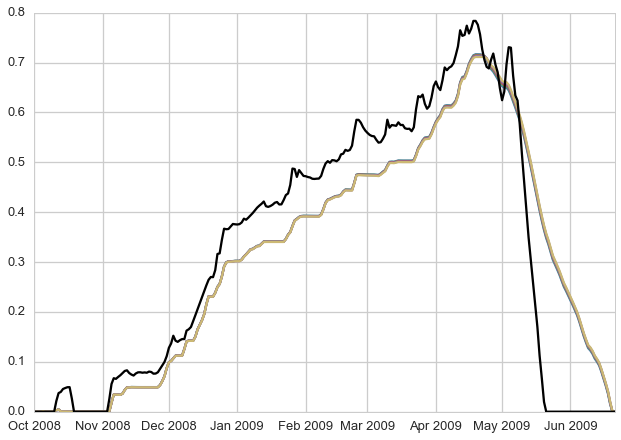

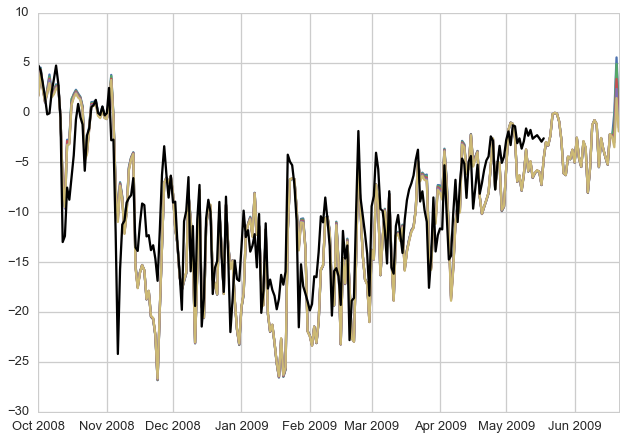

In [16]:
os.chdir(dir_print)
fig,ax = plt.subplots(1,1)
n1 = 10
n2 = 15
for sc in scenarioNames[n1:n2]:
    ax.plot(modelSWE.resample(freq='D',how='mean',dim='time').time,\
            modelSWE.SWE.sel(expNum=sc).resample(freq='D',how='mean',dim='time'))
ax.plot(SWA.resample(freq='d',how='mean',dim='time').time,\
        SWA.SWE.resample(freq='d',how='mean',dim='time'),'k')
# fig.savefig('SASP.SWE.UEBVegzo.TsDemo.png')
    
fig,ax = plt.subplots(1,1)
for sc in scenarioNames[n1:n2]:
    ax.plot(modelTs.resample(freq='d',how='mean',dim='time').time,\
            modelTs.Ts.sel(expNum=sc).resample(freq='d',how='mean',dim='time'))
ax.plot(SWA.resample(freq='d',how='mean',dim='time').time,\
        SWA.Ts.resample(freq='d',how='mean',dim='time'),'k')
# fig.savefig('SASP.Ts.UEBVegzo.TsDemo.png')


-5.0: 0.232998974906
-4.84: 0.232967053368
-4.68: 0.233045649044
-4.52: 0.233056278322
-4.36: 0.233144711032
-4.2: 0.233126419515
-4.04: 0.233163981542
-3.88: 0.233005650497
-3.72: 0.232984132162
-3.56: 0.233089680451
-3.4: 0.233117714699
-3.24: 0.23308639789
-3.08: 0.233264490102
-2.92: 0.233330465647
-2.76: 0.233464642349
-2.6: 0.23351794294
-2.44: 0.233359700255
-2.28: 0.233076900419
-2.12: 0.232967231799
-1.96: 0.232713989993
-1.8: 0.232517865687
-1.64: 0.232264068779
-1.48: 0.231699714268
-1.32: 0.230892197227
-1.16: 0.229851888952


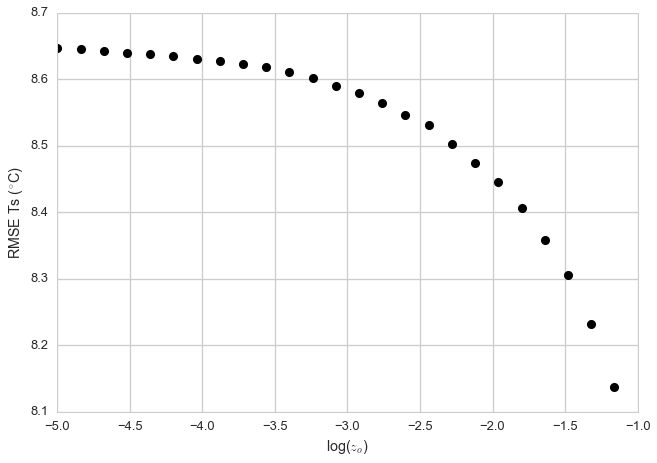

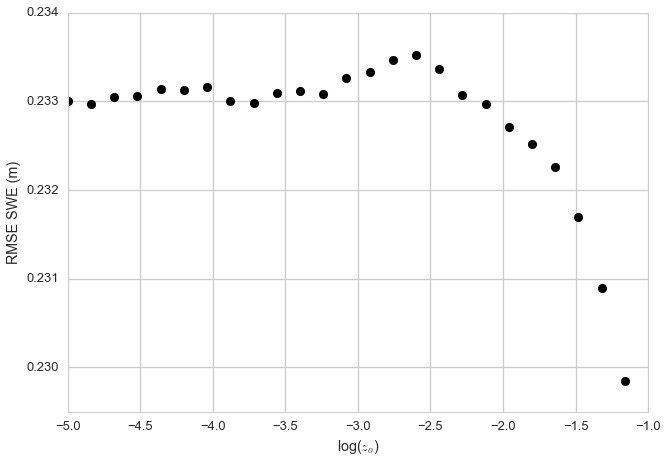

In [17]:
def rmse(model,obs):
    from sklearn.metrics import mean_squared_error
    from math import sqrt

    return(np.nanstd([obs.values, model.values]))

def snowPresentRMSE_Ts(model,obs,SWEmodel,SWEobs):
    indSnowPresent = (SWEmodel > 0) & (SWEobs > 0)
    
    rms = rmse(model[indSnowPresent],obs[indSnowPresent])
    return(rms)

def snowPresentRMSE_SWE(model,obs):
    indSnowPresent = (model > 0) | (obs > 0)
    
    rms = rmse(model[indSnowPresent],obs[indSnowPresent])
    return(rms)

os.chdir(dir_print)
fig,ax = plt.subplots(1,1)
for sc,z in zip(scenarioNames,zo):
    rms = snowPresentRMSE_Ts(modelTs.Ts.sel(expNum=sc),SWA.Ts,modelSWE.SWE.sel(expNum=sc),SWA.SWE)
    ax.plot(np.log10(z),rms,'ko')
ax.set_ylabel('RMSE Ts ($^{\circ}$C)')
ax.set_xlabel('log($z_o$)')
fig.savefig('SASP.Ts_RMSE.UEBVegzo.TsDemo.png')

    
fig,ax = plt.subplots(1,1)
for sc,z in zip(scenarioNames,zo):
    rms = snowPresentRMSE_SWE(modelSWE.SWE.sel(expNum=sc),SWA.SWE)
    ax.plot(np.log10(z),rms,'ko')
    print(str(np.log10(z))+': '+str(rms))
ax.set_ylabel('RMSE SWE (m)')
ax.set_xlabel('log($z_o$)')
fig.savefig('SASP.SWE_RMSE.UEBVegzo.TsDemo.png')


In [15]:
## Load Mark's output
dfSWE = {}
dfTs = {}

for sc,z in zip(scenarioNames,zo):
    # Output filename
    outputFilename = dir_modelOUTPUT_Mark+'/'+siteName+'.'+sc+'.out'
    df = pd.read_csv(outputFilename,sep= '\s', parse_dates={'time' : ['Year','Month','Day','Hour']},\
                date_parser=parser,index_col='time',engine='python')
    dfSWE[sc] = pd.DataFrame(df['SWE(m)'])
    dfTs[sc] = pd.DataFrame(df['Ts(C)'])
    
# Concatenate 
modelSWE = pd.concat(dfSWE,axis=0,keys=scenarioNames)
modelSWE = pd.DataFrame(modelSWE)

modelTs = pd.concat(dfTs,axis=0,keys=scenarioNames)
modelTs = pd.DataFrame(modelTs)

# Convert to xray
modelSWE = xray.Dataset.from_dataframe(modelSWE)
modelSWE = modelSWE.rename({'level_0':'expNum'})

modelTs = xray.Dataset.from_dataframe(modelTs)
modelTs = modelTs.rename({'level_0':'expNum'})

# Rename Data Variables
modelTs = modelTs.rename({'Ts(C)': 'Ts'})
modelSWE = modelSWE.rename({'SWE(m)': 'SWE'})

# Align date
SWA = SWA.reindex_like(modelSWE.time)

print(modelSWE)
print(modelTs)

<xarray.Dataset>
Dimensions:  (expNum: 25, time: 6313)
Coordinates:
  * expNum   (expNum) object 'exp0' 'exp1' 'exp2' 'exp3' 'exp4' 'exp5' ...
  * time     (time) datetime64[ns] 2008-10-01T01:00:00 2008-10-01T02:00:00 ...
Data variables:
    SWE      (expNum, time) float64 1.024e-07 1.941e-07 2.964e-07 3.736e-07 ...
<xarray.Dataset>
Dimensions:  (expNum: 25, time: 6313)
Coordinates:
  * expNum   (expNum) object 'exp0' 'exp1' 'exp2' 'exp3' 'exp4' 'exp5' ...
  * time     (time) datetime64[ns] 2008-10-01T01:00:00 2008-10-01T02:00:00 ...
Data variables:
    Ts       (expNum, time) float64 -5.359 -5.828 -5.869 -5.733 -6.61 -7.453 ...
